
# Project 2: swarming behavior and correlated velocities

In this project you will explore the properties of the [Vicsek swarming model](https://en.wikipedia.org/wiki/Vicsek_model) and you will generalize it by adding rules to the interactions of the active particles in the system.

The model has an internal noise parameter ("$eta$" in the implementation below), and it is known that increasing $eta$ from $0$ to $1$ will lead the swarm to undergo a phase transition, i.e. a qualitative change of behavior, which in this case manifests itself as a passage from collective, ordered motion to random motion for the active particles. 

Referring to the concepts of polarization, correlation function, and correlation length defined in the article [Scale-free correlations in starling flocks](https://www.pnas.org/content/107/26/11865), answer the following questions:


(1) Estimate the value of $eta$ for which there is a phase transition in the Vicsek model, by using the polarization $\Phi$ of the system. Test your method for several values of size $N$ of the system, and several choices of initial random distributions of the active particles.


(2) Estimate the correlation function $C(r)$ of fluctuations of velocities within the Vicsek model, for multiple values of $eta$ and for $N \approx 10^3$. Estimate $\bar r$, the value of $r$ for which $C(r)$ becomes zero ($\bar r$ is an estimate of the correlation length of the swarm). 


(3) Research the literature to find other swarming and flocking models. On the basis of your literature review and your intuition, try to modify the Vicsek model so that you increase the average value of $\bar r$ for the swarm.  

N.B. all your answers should be in reference to the system in an "asymptotic" state when the initial random distribution of the positions and velocities of the active particles is no more significant to the dynamics.



This code template is taken from a blog post of [Francesco Turci](https://francescoturci.net/2020/06/19/minimal-vicsek-model-in-python/), a researcher in disordered systems. This specific Python implementation allows you to simulate far more active particles than it would be possible with a direct, naive implementation of the Vicsek model.

In [7]:
import numpy as np
import scipy as sp
from scipy import sparse
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib notebook

L = 32.0
rho = 3.0
N = int(rho*L**2)
print(" N",N)
 
r0 = 1.0
deltat = 1.0
factor = 0.5
v0 = r0/deltat*factor
iterations = 1000
eta = 0

pos = np.random.uniform(0,L,size=(N,2))
orient = np.random.uniform(-np.pi, np.pi,size=N)

#Sets initial pos and orient values in this cell so they cannot accidentally be altered in later versions
pos0 = pos
orient0 = orient

 N 3072


In [8]:
def Vicsek(pos, orient, eta):
    
    tree = cKDTree(pos,boxsize=[L,L])
    dist = tree.sparse_distance_matrix(tree, max_distance=r0,output_type='coo_matrix')
 
    data = np.exp(orient[dist.col]*1j)
    neigh = sparse.coo_matrix((data,(dist.row,dist.col)), shape=dist.get_shape())
    S = np.squeeze(np.asarray(neigh.tocsr().sum(axis=1)))
        
    orient = np.angle(S)+eta*np.random.uniform(-np.pi, np.pi, size=N)
        
    cos, sin= np.cos(orient), np.sin(orient)
    pos[:,0] += cos*v0
    pos[:,1] += sin*v0

    pos[pos>L] -= L
    pos[pos<0] += L
    
    return pos, orient

In [9]:
def Polarization(orient, N):
    v = (np.cos(orient), np.sin(orient))
    v_sum = np.sum(v, axis=1)
    v_mod = v_sum * (1/N)
    phi = np.linalg.norm(v_mod)
    return phi

In [42]:
def Correlation(r):
    global pos, orient, N, delta_r
    
    #Get v_mod () and v_mean ()
    v = (np.cos(orient), np.sin(orient))
    v_sum = np.sum(v, axis=1)
    v_mod = v_sum * (1/N)
    v_mean = np.mean(v)
    
    sumtop = 0
    sumbot = 0

    #ui = x-component of v_mod, uj = y-component of v_mod
    ui = v_mod[0] - v_mean
    uj = v_mod[1] - v_mean
    
    for i in range(N):
        for j in range(N):
            #Get distance between two positions
            pos_1 = pos[i]
            pos_2 = pos[j]
            
            pos_1x = pos_1[0]
            pos_1y = pos_1[1]
            pos_2x = pos_2[0]
            pos_2y = pos_2[1]
            
            sub_x = (pos_1x - pos_2x)**2
            sub_y = (pos_1y - pos_2y)**2
            
            r_ij = (sub_x + sub_y)**0.5
            
            r_test = np.abs(r_ij - r)
            
            #Determine if distance is significant enough to add the dot project of ui/uj to the sum
            if r_test < delta_r:
                sumtop += np.dot(ui, uj)
                sumbot += 1
    
    Cr = sumtop / sumbot
    
    print("Cr for r =",r,":",Cr)
    
    return Cr

In [ ]:
times = 21
count = 0
eta_values = np.linspace(0, 1, times)

polarization_points = np.zeros(times)

for eta in eta_values:
    pos = pos0
    orient = orient0
    for i in range(iterations):
        pos, orient = Vicsek(pos, orient, eta)
    polarization_points[count] = Polarization(orient, N)
    count += 1

In [48]:
polarization_points = np.array([0.99780336, 0.99058764, 0.97364181, 0.93967504, 0.88890097, 0.8502684,
 0.77818856, 0.6969395,  0.60919501, 0.48612414, 0.33344645, 0.13122521,
 0.03018237, 0.02262282, 0.03426731, 0.03821556, 0.0093103,  0.0082163,
 0.0148618,  0.015963,  ])
eta_values = np.linspace(0, 1, 20)

In [49]:
#Citation: Professor Napoletani

jump = np.abs(polarization_points[1:]-polarization_points[:-1])
mm = np.mean(jump[-20:])

posMax = np.argmax(jump)
inde1 = posMax

Djump = jump[inde1]
while Djump > mm:
    Djump = jump[inde1]
    inde1 += 1
    
print("Estimated eta value for phase transition:", eta_values[inde1+1])

Estimated eta value for phase transition: 0.7368421052631579


In [52]:
#Define masking function for phase shift
def masks(vec):
    d = np.diff(vec)
    # Mask of locations where graph stabilizes horizontally (slope difference is not greater or less than 0.05)
    to_mask = 0.7

    return to_mask

to_horiz_mask = masks(polarization_points)

#Define function to apply defined mask function to all points on the graph
def apply_mask(mask, x, y):
    return x[1:-1][mask], y[1:-1][mask]

to_horiz_eta, to_horiz_phi = apply_mask(to_horiz_mask, eta_values, polarization_points)

#Generate plot with masked points layered on top
plt.plot(eta_values, polarization_points, 'b-')
plt.plot(to_horiz_eta, to_horiz_phi, 'r>', label='Plot stabilizes horizontally')
plt.legend()
plt.show()
#From this plot we can clearly see where the "phase shift" occurs as discussed in class

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

<IPython.core.display.Javascript object>


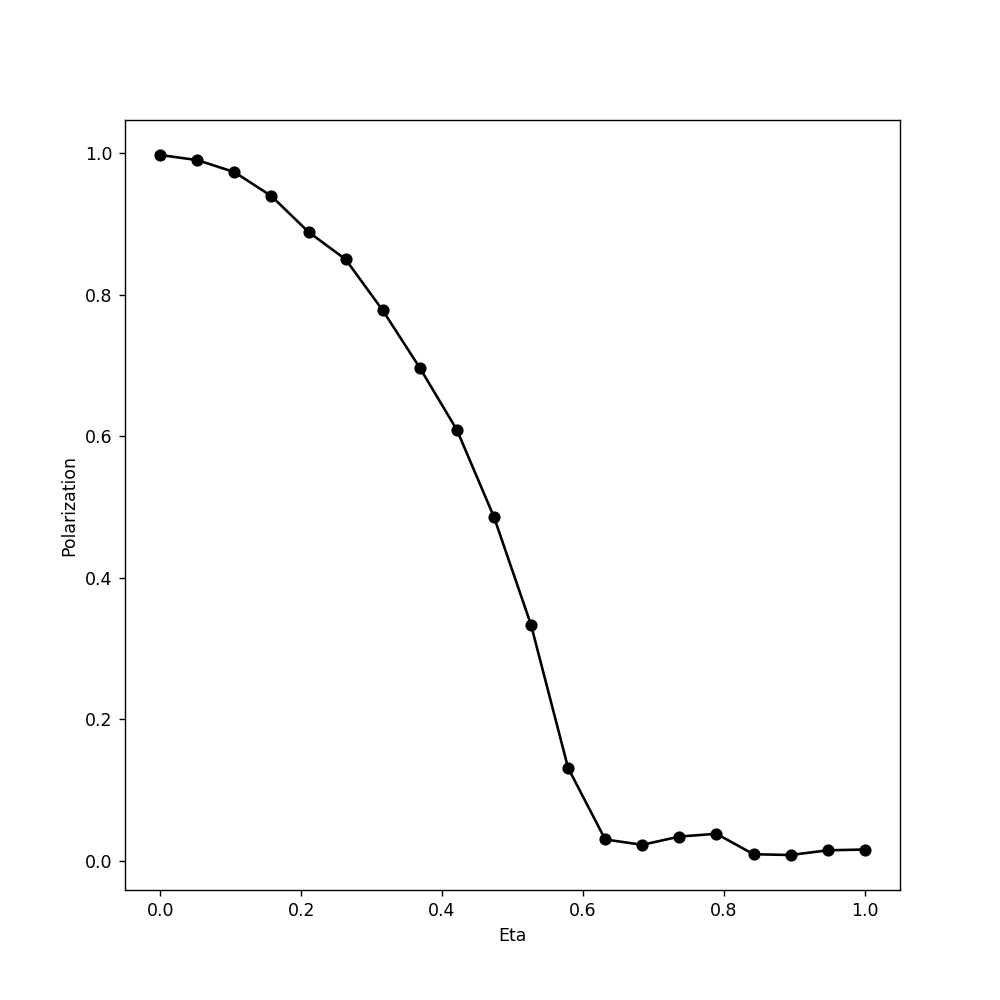

Text(0, 0.5, 'Polarization')

In [51]:
fig1, ax1 = plt.subplots(1, 1, figsize=(8, 8))
ax1.plot(eta_values, polarization_points, "ro-", color = "black")
plt.xlabel("Eta")
plt.ylabel("Polarization")

In [43]:
times = 5
r_points = np.linspace(0, 32, times)
delta_r = 0.03
eta = 0.1
count = 0

correlation_points = np.zeros(times)

for i in range(times):
    pos = pos0
    orient = orient0
    for i in range(iterations):
        pos, orient = Vicsek(pos, orient, eta)
    r = r_points[count]
    correlation_points[count] = Correlation(r)
    count += 1

Cr for r = 0.0 : -0.03436908573911121
Cr for r = 1.0 : -0.03575167321681988
Cr for r = 2.0 : -0.008083030246723395
Cr for r = 3.0 : -0.02609448245072608
Cr for r = 4.0 : -0.0004702281128349762
Cr for r = 5.0 : -0.0013131806501848313
Cr for r = 6.0 : -0.05622921135503389
Cr for r = 7.0 : -0.10076587572375675
Cr for r = 8.0 : -0.006401654817178872
Cr for r = 9.0 : -0.03779574231967796
Cr for r = 10.0 : -0.046035476396361026
Cr for r = 11.0 : -0.014788152515643627
Cr for r = 12.0 : -0.01925524640593408
Cr for r = 13.0 : -0.05376038071874157
Cr for r = 14.0 : -0.001220802373890064
Cr for r = 15.0 : -0.05061528614178448
Cr for r = 16.0 : -0.016922670855491487
Cr for r = 17.0 : -0.0003350338545047407
Cr for r = 18.0 : -0.020596658962688072
Cr for r = 19.0 : -0.00019090837796297894
Cr for r = 20.0 : -0.021750967555432772
Cr for r = 21.0 : -0.015122596807146045


KeyboardInterrupt: 

In [ ]:
times = 5
r_points = np.linspace(0, 32, times)
delta_r = 0.03
eta = 0.5
count = 0

correlation_points = np.zeros(times)

for i in range(times):
    pos = pos0
    orient = orient0
    for i in range(iterations):
        pos, orient = Vicsek(pos, orient, eta)
    r = r_points[count]
    correlation_points[count] = Correlation(r)
    count += 1

In [ ]:
times = 5
r_points = np.linspace(0, 32, times)
delta_r = 0.03
eta = 0.9
count = 0

correlation_points = np.zeros(times)

for i in range(times):
    pos = pos0
    orient = orient0
    for i in range(iterations):
        pos, orient = Vicsek(pos, orient, eta)
    r = r_points[count]
    correlation_points[count] = Correlation(r)
    count += 1

In [ ]:
times = 5
r_points = np.linspace(0, 32, times)
delta_r = 0.03
eta = 0.5
count = 0
N = 10000

correlation_points = np.zeros(times)

for i in range(times):
    pos = pos0
    orient = orient0
    for i in range(iterations):
        pos, orient = Vicsek(pos, orient, eta)
    r = r_points[count]
    correlation_points[count] = Correlation(r)
    count += 1

In [ ]:
fig2, ax2 = plt.subplots(1, 1, figsize=(8, 8))
plt.xlabel("r points")
plt.ylabel("Correlation")
ax2.plot(r_points, correlation_points ,"ro-", color = "black")